In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from unet_keras import *


import tensorflow as tf
from param_config import *
from data_augmentation import *
import shutil


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]

Using TensorFlow backend.


In [2]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [05:33<00:00,  2.01it/s]


In [4]:
def data_aug(image,label,angel=30,resize_rate=0.9):
    flip = random.randint(0, 1)
    size = image.shape[0]
    rsize = random.randint(np.floor(resize_rate*size),size)
    w_s = random.randint(0,size - rsize)
    h_s = random.randint(0,size - rsize)
    sh = random.random()/2-0.25
    rotate_angel = random.random()/180*np.pi*angel
    # Create Afine transform
    afine_tf = transform.AffineTransform(shear=sh,rotation=rotate_angel)
    # Apply transform to image data
    image = transform.warp(image, inverse_map=afine_tf,mode='edge')
    label = transform.warp(label, inverse_map=afine_tf,mode='edge')
    # Randomly corpping image frame
    image = image[w_s:w_s+size,h_s:h_s+size,:]
    label = label[w_s:w_s+size,h_s:h_s+size]
    # Ramdomly flip frame
    if flip:
        image = image[:,::-1,:]
        label = label[:,::-1]
    return image, label

def make_data_augmentation(image_ids,images,masks,split_num):
    for image_id,image, labels in zip(image_ids,images,masks):
        if not os.path.exists(TRAIN_PATH+"/{}/augs/".format(image_id)):
            os.makedirs(TRAIN_PATH+"/{}/augs/".format(image_id))
        if not os.path.exists(TRAIN_PATH+"/{}/augs_masks/".format(image_id)):
            os.makedirs(TRAIN_PATH+"/{}/augs_masks/".format(image_id))
        # also save the original image in augmented file 
        plt.imsave(fname=TRAIN_PATH+"/{}/augs/{}.png".format(image_id,image_id), arr = image)
        plt.imsave(fname=TRAIN_PATH+"/{}/augs_masks/{}.png".format(image_id,image_id),arr = np.squeeze(labels))

        for i in range(split_num):
            new_image, new_labels = data_aug(image,labels,angel=5,resize_rate=0.9)
            aug_img_dir = TRAIN_PATH+"/{}/augs/{}_{}.png".format(image_id,image_id,i)
            aug_mask_dir = TRAIN_PATH+"/{}/augs_masks/{}_{}.png".format(image_id,image_id,i)
            plt.imsave(fname=aug_img_dir, arr = new_image)
            plt.imsave(fname=aug_mask_dir,arr = np.squeeze(new_labels))

def clean_data_augmentation(image_ids):
    for ax_index, image_id in tqdm(enumerate(image_ids),total=len(image_ids)):
        print(image_id)
        if os.path.exists(TRAIN_PATH+"/{}/augs/".format(image_id)):
            shutil.rmtree(TRAIN_PATH+"/{}/augs/".format(image_id))
        if os.path.exists(TRAIN_PATH+"/{}/augs_masks/".format(image_id)):
            shutil.rmtree(TRAIN_PATH+"/{}/augs_masks/".format(image_id))

            
split_num = 10
make_data_augmentation(train_ids,X_train,Y_train,split_num)
#clean_data_augmentation(train_ids)

In [5]:
def get_augmented_data(train_ids,split_num):
    aug_num=split_num+1
    X_aug_train = np.zeros((len(train_ids)*aug_num, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_aug_train = np.zeros((len(train_ids)*aug_num, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    print('Getting and resizing augmented train images and masks ... ')
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        path = TRAIN_PATH + id_
        img = imread(path + '/augs/' + id_ +'.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_aug_train[n*aug_num] = img
        mask = imread(path + '/augs_masks/' + id_ +'.png')[:,:,0]
        mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                          preserve_range=True), axis=-1)
        mask[mask==1]=0
        mask[mask>0]=1
        Y_aug_train[n*aug_num] = mask
        for i in range(split_num):
            img = imread(path + '/augs/' + id_ +"_"+str(i)+'.png')[:,:,:IMG_CHANNELS]
            img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            X_aug_train[n*aug_num+i] = img
            mask = imread(path + '/augs_masks/' + id_ +"_"+str(i)+'.png')[:,:,0]
            mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                         preserve_range=True), axis=-1)
            mask[mask==1]=0
            mask[mask>0]=1
            Y_aug_train[n*aug_num+i] = mask
    return X_aug_train,Y_aug_train
split_num=10
X_aug_train,Y_aug_train=get_augmented_data(train_ids,split_num)

Getting and resizing augmented train images and masks ... 


100%|██████████| 670/670 [00:55<00:00, 12.12it/s]


7370 7370


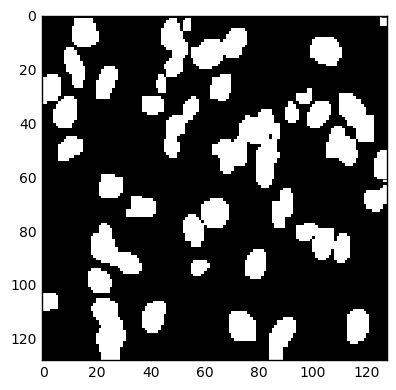

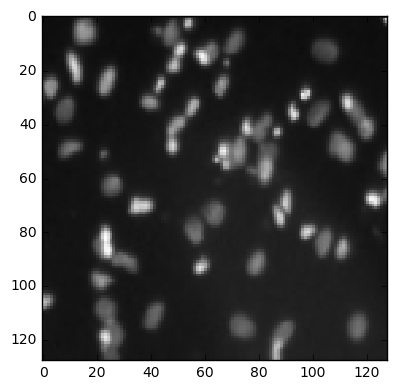

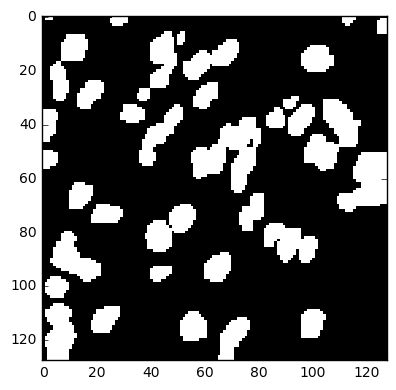

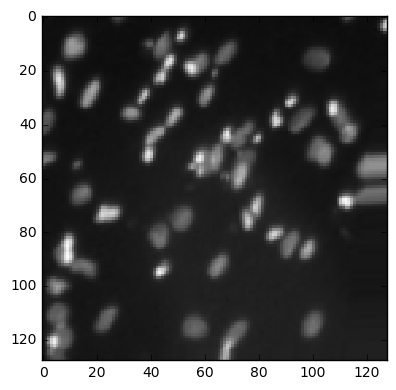

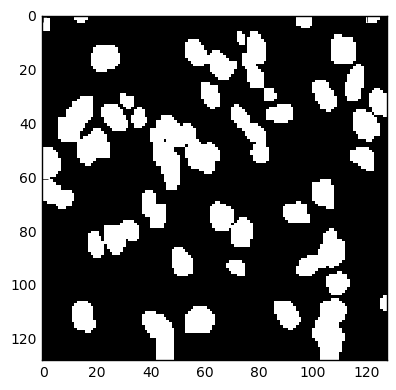

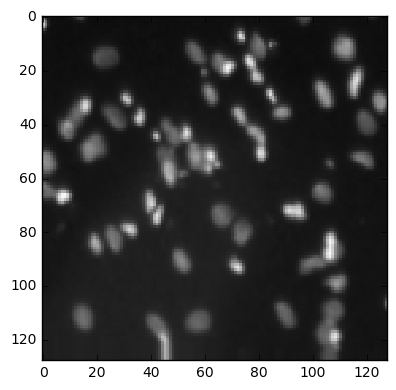

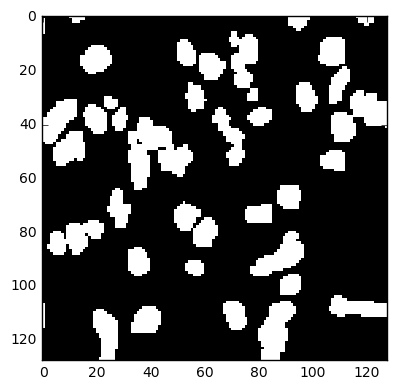

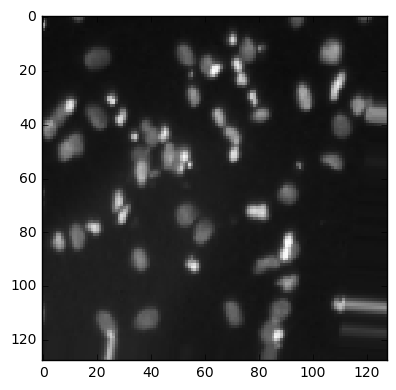

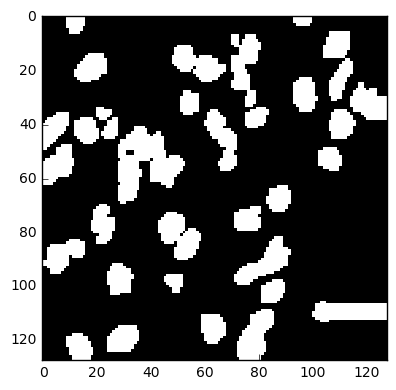

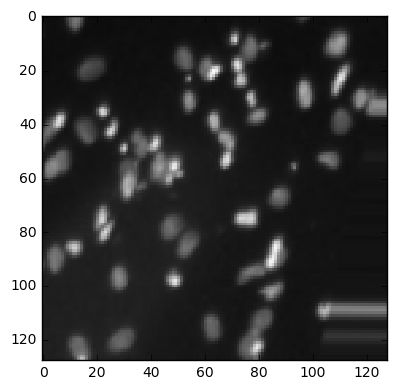

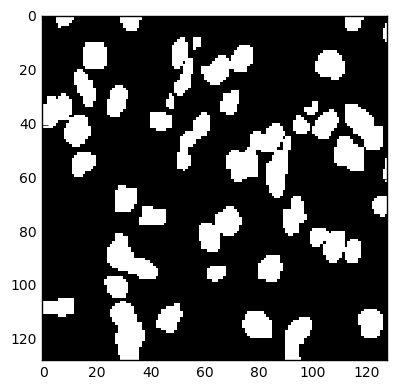

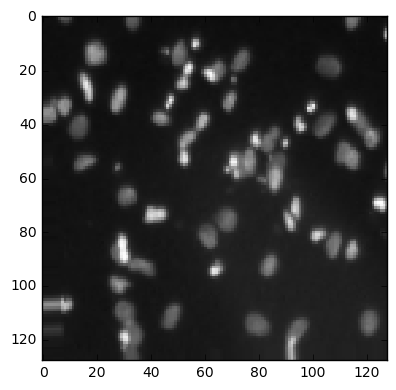

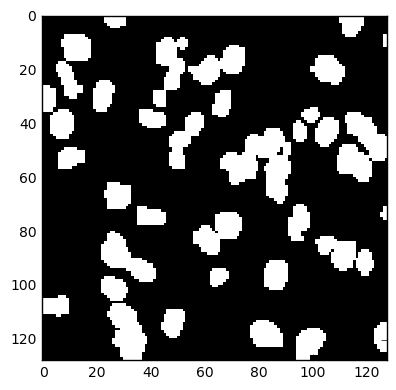

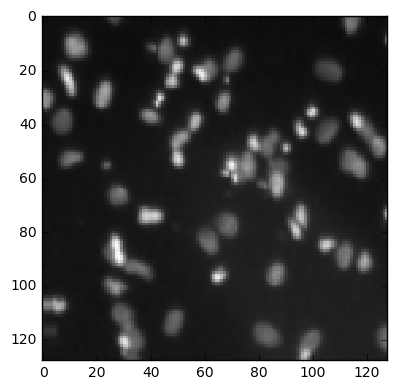

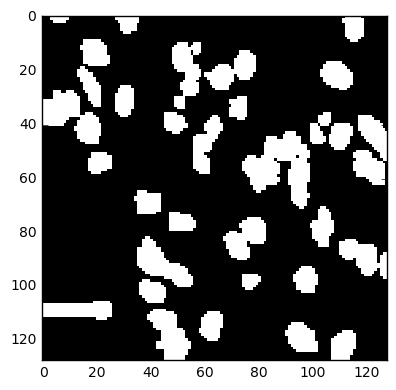

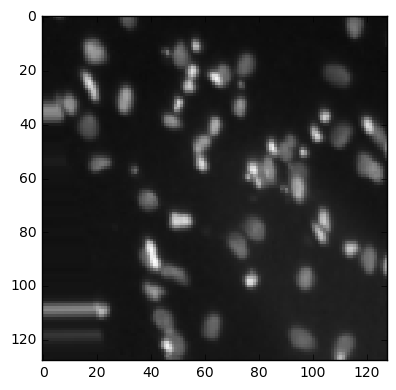

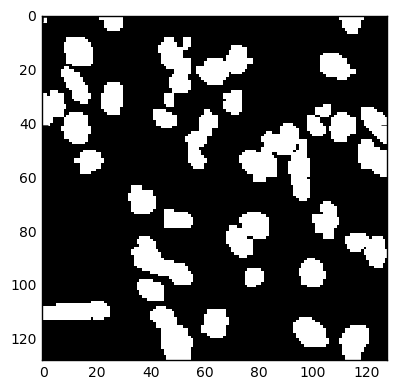

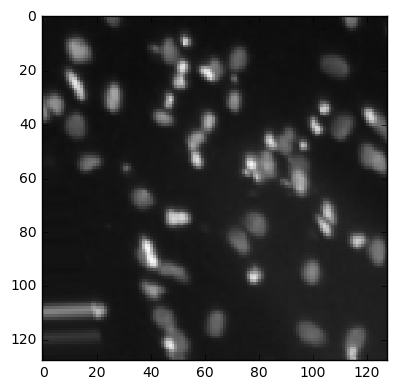

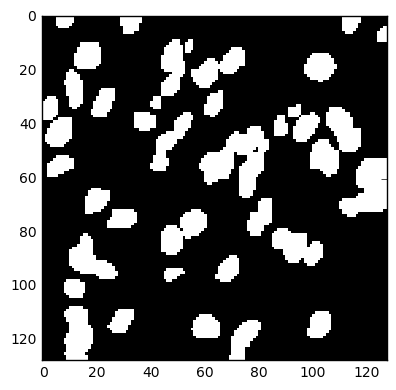

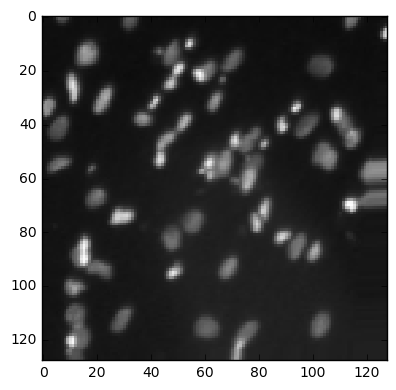

In [6]:
print(len(X_aug_train),len(Y_aug_train))
ix = random.randint(0, len(train_ids))
aug_num=split_num+1
for i in range(split_num):
    imshow(np.squeeze(Y_aug_train[ix*aug_num+i]))
    plt.show()
    imshow(X_aug_train[ix*aug_num+i])
    plt.show()

In [9]:
model=unet()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-augm-100.h5', verbose=1, save_best_only=True)
results = model.fit(X_aug_train, Y_aug_train, validation_split=0.1, batch_size=16, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
dropout_19 (Dropout)         (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 64, 64, 32)        4640      
__________

ResourceExhaustedError: OOM when allocating tensor with shape[16,16,128,128]
	 [[Node: conv2d_40/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](dropout_19/cond/Merge, conv2d_40/kernel/read)]]
	 [[Node: mean_iou_23/confusion_matrix/transpose/_933 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1382_mean_iou_23/confusion_matrix/transpose", tensor_type=DT_INT64, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'conv2d_40/convolution', defined at:
  File "/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/apps/gcc4_9/python3/3.5.2/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-ddd614e80e5c>", line 1, in <module>
    model=unet()
  File "/home/05268/junma7/deepLearning/kaggle18/unet_keras.py", line 35, in unet
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
  File "/home/05268/junma7/.local/lib/python3.5/site-packages/keras/engine/topology.py", line 545, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/05268/junma7/.local/lib/python3.5/site-packages/keras/layers/convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "/home/05268/junma7/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 2864, in conv2d
    data_format='NHWC')
  File "/opt/apps/gcc4_9/cuda8_0/cudnn5_1/python3_5/tensorflow-gpu/1.0.0/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 639, in convolution
    op=op)
  File "/opt/apps/gcc4_9/cuda8_0/cudnn5_1/python3_5/tensorflow-gpu/1.0.0/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 308, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/opt/apps/gcc4_9/cuda8_0/cudnn5_1/python3_5/tensorflow-gpu/1.0.0/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 631, in op
    name=name)
  File "/opt/apps/gcc4_9/cuda8_0/cudnn5_1/python3_5/tensorflow-gpu/1.0.0/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 129, in _non_atrous_convolution
    name=name)
  File "/opt/apps/gcc4_9/cuda8_0/cudnn5_1/python3_5/tensorflow-gpu/1.0.0/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 396, in conv2d
    data_format=data_format, name=name)
  File "/opt/apps/gcc4_9/cuda8_0/cudnn5_1/python3_5/tensorflow-gpu/1.0.0/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/opt/apps/gcc4_9/cuda8_0/cudnn5_1/python3_5/tensorflow-gpu/1.0.0/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/opt/apps/gcc4_9/cuda8_0/cudnn5_1/python3_5/tensorflow-gpu/1.0.0/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[16,16,128,128]
	 [[Node: conv2d_40/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](dropout_19/cond/Merge, conv2d_40/kernel/read)]]
	 [[Node: mean_iou_23/confusion_matrix/transpose/_933 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1382_mean_iou_23/confusion_matrix/transpose", tensor_type=DT_INT64, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
